In [2]:
!python -V

Python 3.10.12


In [3]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 799.5 kB/s eta 0:00:00


In [4]:
!git clone https://github.com/joon999/aiku-23-2-whos-that-pokemon

Cloning into 'aiku-23-2-whos-that-pokemon'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (94/94), done.
remote: Total 210 (delta 5), reused 82 (delta 2), pack-reused 113
Receiving objects: 100% (210/210), 2.00 MiB | 4.01 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [5]:
import torch
import torch.nn as nn

from torch import Tensor
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.utils as vutils


In [41]:
import os
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from einops.layers.torch import Rearrange


In [7]:
print(torch.__version__)

2.1.0+cu121


In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_poke = 1

epoch = 3600
batch_size = 16
lr = 2e-4

In [9]:
class SilhouetteDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.silhouette_dir = os.path.join(root_dir, 'pikachu_sil_128') # 데이터셋의 각 폴더명 수정해서 사용
        self.original_dir = os.path.join(root_dir, 'pikachu_128')

        self.silhouette_filenames = os.listdir(self.silhouette_dir)

    def __len__(self):
        return len(self.silhouette_filenames)

    def __getitem__(self, idx):
        silhouette_path = os.path.join(self.silhouette_dir, self.silhouette_filenames[idx])
        original_path = os.path.join(self.original_dir, self.silhouette_filenames[idx])

        silhouette_image = Image.open(silhouette_path)
        original_image = Image.open(original_path)

        if self.transform:
            silhouette_image = self.transform(silhouette_image)
            original_image = self.transform(original_image)

        return silhouette_image, original_image

In [10]:
def convert_4channel_to_3channel(image):
    image = image[:3, :, :]
    return image


In [11]:
# 데이터셋의 루트 디렉토리 수정해서 사용
root_dir = '/content/aiku-23-2-whos-that-pokemon/dataset/'

# 전처리 및 데이터 증강을 위한 변환 정의
transform = transforms.Compose([
    transforms.ToTensor(),
    convert_4channel_to_3channel,
])

In [70]:
# 데이터셋 생성
dataset = SilhouetteDataset(root_dir, transform=transform)

train_size = 0.8
#indices = list(range(len(dataset)))
train_dataset, test_dataset = train_test_split(dataset, train_size=train_size, shuffle=True, random_state=42)

# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

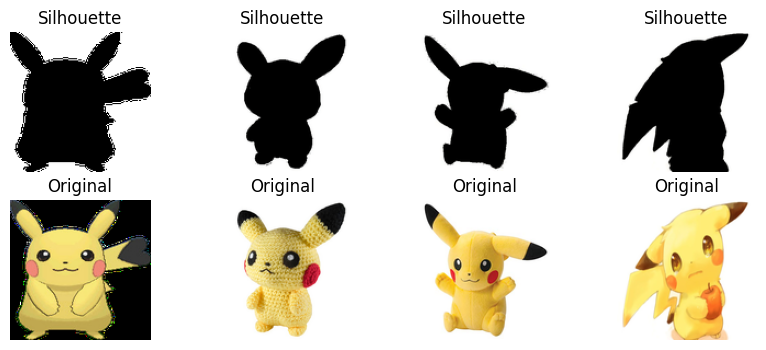

In [71]:
# 몇 개의 샘플을 시각화
num_samples_to_show = 4
fig, axes = plt.subplots(2, num_samples_to_show, figsize=(10, 4))

for i in range(num_samples_to_show):
    silhouette_image, original_image = dataset[i]

    # 시각화를 위해 텐서를 이미지로 변환
    silhouette_image = vutils.make_grid(silhouette_image, normalize=True).numpy().transpose(1, 2, 0)
    original_image = vutils.make_grid(original_image, normalize=True).numpy().transpose(1, 2, 0)

    axes[0, i].imshow(silhouette_image, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Silhouette')

    axes[1, i].imshow(original_image)
    axes[1, i].axis('off')
    axes[1, i].set_title('Original')

plt.show()

In [14]:
o1, o2 = next(iter(train_dataloader))
o2.shape

torch.Size([16, 3, 128, 128])

In [15]:
class ConvBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()

        self.conv_seq = nn.Sequential(
            self.get_conv_block(c_in, c_out),
            self.get_conv_block(c_out, c_out)
        )

    def get_conv_block(self, c_in, c_out):
        return nn.Sequential(
            nn.Conv2d(c_in, c_out, (3, 3), 1, 1),
            nn.BatchNorm2d(c_out),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv_seq(x)


In [16]:
class EncoderBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()

        self.conv_block = ConvBlock(c_in, c_out)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.conv_block(x)
        x2 = self.maxpool(x1)

        return x1, x2


In [17]:
class DecoderBlock(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()

        self.upconv = nn.ConvTranspose2d(c_in, c_in // 2, (2, 2), 2)
        self.conv_block = ConvBlock(c_in, c_out)

    def forward(self, x, residual):
        x1 = self.upconv(x)
        x2 = torch.cat((x1, residual), dim=1)
        x3 = self.conv_block(x2)

        return x3


In [18]:
class NoiseBlock(nn.Module): # (128, 1, 1) -> (512, 16, 16)
    def __init__(self):
        super().__init__()

        self.deconv1 = nn.ConvTranspose2d(128, 256, (4, 4))
        self.deconv2 = nn.ConvTranspose2d(256, 256, (2, 2), 2)
        self.deconv3 = nn.ConvTranspose2d(256, 512, (2, 2), 2)

    def forward(self, x):
        x1 = self.deconv1(x)
        x2 = self.deconv2(x1)
        x3 = self.deconv3(x2)

        return x3


In [19]:
class PokeGen(nn.Module):
    def __init__(
        self,
        num_poke: int,
    ):
        super().__init__()
        self.noise_emb = nn.Embedding(num_poke, 128)
        self.noise_block = NoiseBlock()
        self.unsqueeze = Rearrange('b c -> b c () ()')

        self.ue1 = EncoderBlock(3, 64)    # (3, 128)  -> (64, 64)
        self.ue2 = EncoderBlock(64, 128)  # (64, 64)  -> (128, 32)
        self.ue3 = EncoderBlock(128, 256) # (128, 32) -> (256, 16)

        self.bridge = ConvBlock(256, 512) # (256, 16) -> (512, 16)

        self.ud1 = DecoderBlock(512, 256) # (512, 16) -> (256, 32)
        self.ud2 = DecoderBlock(256, 128) # (256, 32) -> (128, 64)
        self.ud3 = DecoderBlock(128, 64)  # (128, 64) -> (64, 128)

        self.final = nn.Sequential(
            ConvBlock(64, 3),
            nn.Tanh()
        )

    def forward(
        self,
        label: Tensor,
        mask: Tensor
    ):
        """
        Args:
            label: (B) tensor containing the labels of each pokemon
            mask: (B, 3, 128, 128) binary mask tensor
        """
        noise = self.noise_emb(label) # (B, 128)
        noise = self.unsqueeze(noise)
        n = self.noise_block(noise)

        r1, x1 = self.ue1(mask)
        r2, x2 = self.ue2(x1)
        r3, x3 = self.ue3(x2)

        x4 = self.bridge(x3) + n

        x5 = self.ud1(x4, r3)
        x6 = self.ud2(x5, r2)
        x7 = self.ud3(x6, r1)

        output = self.final(x7)

        return output

In [20]:
label = torch.randint(0, 10, (10,))
mask = torch.randn((10, 3, 128, 128))

model = PokeGen(10)
output = model(label, mask)

print(output.shape)

torch.Size([10, 3, 128, 128])


In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.ue1 = EncoderBlock(3, 64)    # (3, 128)  -> (64, 64)
        self.ue2 = EncoderBlock(64, 128)  # (64, 64)  -> (128, 32)
        self.ue3 = EncoderBlock(128, 256) # (128, 32) -> (256, 16)
        self.ue4 = EncoderBlock(256, 256) # (256, 16) -> (256, 8)

        self.flatten = Rearrange('b c h w -> b (c h w)')

        self.fc1 = nn.Linear(256 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        _, x1 = self.ue1(x)
        _, x2 = self.ue2(x1)
        _, x3 = self.ue3(x2)
        _, x4 = self.ue4(x3)

        x5 = self.flatten(x4)
        x6 = self.fc1(x5)
        x7 = self.fc2(x6)

        return self.sig(x7)


In [22]:
x = torch.randn((10, 3, 128, 128))
model = Discriminator()
output = model(x)
print(output.shape)

torch.Size([10, 1])


In [72]:
poke_gen = PokeGen(num_poke).to(device)
disc = Discriminator().to(device)

In [73]:
poke_gen.train()
disc.train()

print('')

In [74]:
opt_poke_gen = optim.Adam(poke_gen.parameters())
opt_disc = optim.Adam(disc.parameters())

crit1 = nn.BCELoss()
crit2 = nn.L1Loss()

In [75]:
result_dict = {
    'loss':[],
    'imgs':[],
}

In [76]:
for e in tqdm(range(epoch)):
    poke_gen.train()

    for data in train_dataloader:
        mask, image = data
        cur_batch_size = image.size(0)

        image = image.to(device)
        mask = mask.to(device)

        label = torch.full((cur_batch_size,), 0, dtype=torch.int, device=device)

        label_real = torch.full((cur_batch_size, 1), 1.0, device=device)
        label_fake = torch.full((cur_batch_size, 1), 0.0, device=device)

        # train gen
        poke_gen.zero_grad()

        fake_image = poke_gen(label, mask)
        disc_output = disc(fake_image)

        loss_gen = crit1(disc_output, label_real)
        loss_gen += crit2(image, fake_image)

        loss_gen.backward()
        opt_poke_gen.step()

        # train disc
        disc.zero_grad()

        disc_output = disc(image)
        loss_disc = crit1(disc_output, label_real)

        disc_output = disc(fake_image.detach())
        loss_disc += crit1(disc_output, label_fake)

        loss_disc.backward()
        opt_disc.step()

    if e % 10 == 0:
        poke_gen.eval()

        sample_label = torch.zeros((14,), dtype=torch.int, device=device)
        sample_mask, sample_origin = next(iter(test_dataloader))

        sample_img = poke_gen(sample_label.to(device), sample_mask.to(device))

        result_dict['imgs'].append(sample_img[0].detach())

100%|██████████| 3600/3600 [1:18:54<00:00,  1.32s/it]


In [127]:
result_dict['imgs'][0].shape

torch.Size([3, 128, 128])

In [143]:
# prompt: save images in the list 'result_dict['imgs']' which is the tensor list on cuda

for i, img in enumerate(result_dict['imgs']):
    vutils.save_image(img, f'output_poke2/{i:03d}.jpg')


In [146]:
# prompt: make gif with the images on output_poke folder, they have 0, 1, 2,... order naming

import imageio
import os

filenames = os.listdir('output_poke2')
filenames.sort()

images = []
for filename in filenames:
    images.append(imageio.imread(os.path.join('output_poke2', filename)))

imageio.mimsave('output_poke2.gif', images, duration=0.001)


<ipython-input-146-0d0edcb892fd>:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('output_poke2', filename)))


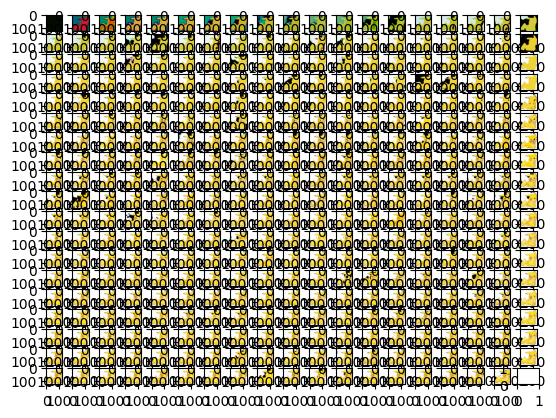

In [79]:
fig, axs = plt.subplots(19, 19)
for i, img in enumerate(result_dict['imgs']):
    axs[i // 19, i % 19].imshow(img.cpu().permute(1, 2, 0))
plt.show()


In [102]:
poke_gen.eval()

sample_label = torch.zeros((14,), dtype=torch.int, device=device)
sample_mask, sample_origin = next(iter(test_dataloader))

sample_img = poke_gen(sample_label.to(device), sample_mask.to(device))

In [103]:
img = sample_img[3].detach()
img.shape

torch.Size([3, 128, 128])

In [104]:
sample_mask.shape

torch.Size([14, 3, 128, 128])

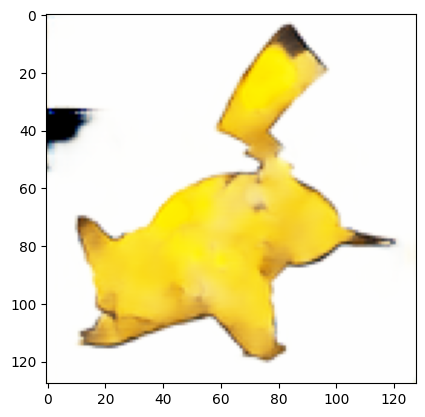

In [100]:
import matplotlib
#plt.imshow(img.cpu().numpy().transpose(1, 2, 0), norm=matplotlib.colors.Normalize())
plt.imshow(img.cpu().numpy().transpose(1, 2, 0))

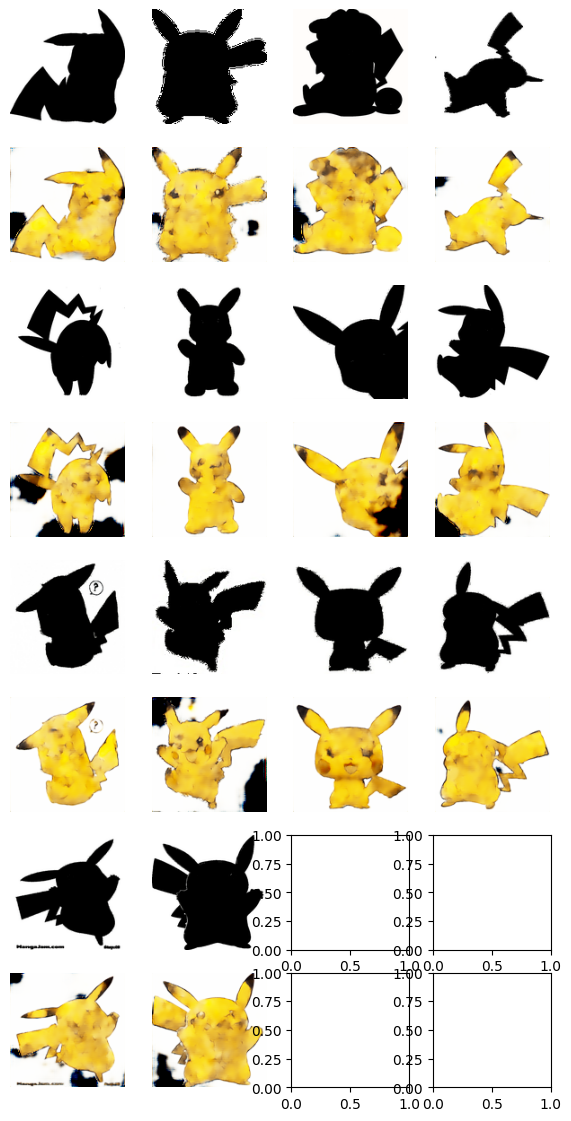

In [111]:
num_samples_to_show = 14
fig, axes = plt.subplots(8, 4, figsize=(7, 14))

for i in range(num_samples_to_show):
    sample_maski = sample_mask[i].numpy().transpose(1, 2, 0)
    sample_imgi = sample_img[i].detach().cpu().numpy().transpose(1, 2, 0)

    axes[(i // 4) * 2, i % 4].imshow(sample_maski, cmap='gray')
    axes[(i // 4) * 2, i % 4].axis('off')

    axes[(i // 4) * 2 + 1, i % 4].imshow(sample_imgi)
    axes[(i // 4) * 2 + 1, i % 4].axis('off')

plt.show()

In [139]:
torch.save({
    'poke_gen_state_dict': poke_gen.state_dict(),
    'disc_state_dict': disc.state_dict(),
    'opt_poke_gen_state_dict': opt_poke_gen.state_dict(),
    'opt_disc_state_dict': opt_disc.state_dict(),
}, 'checkpoint.pt')


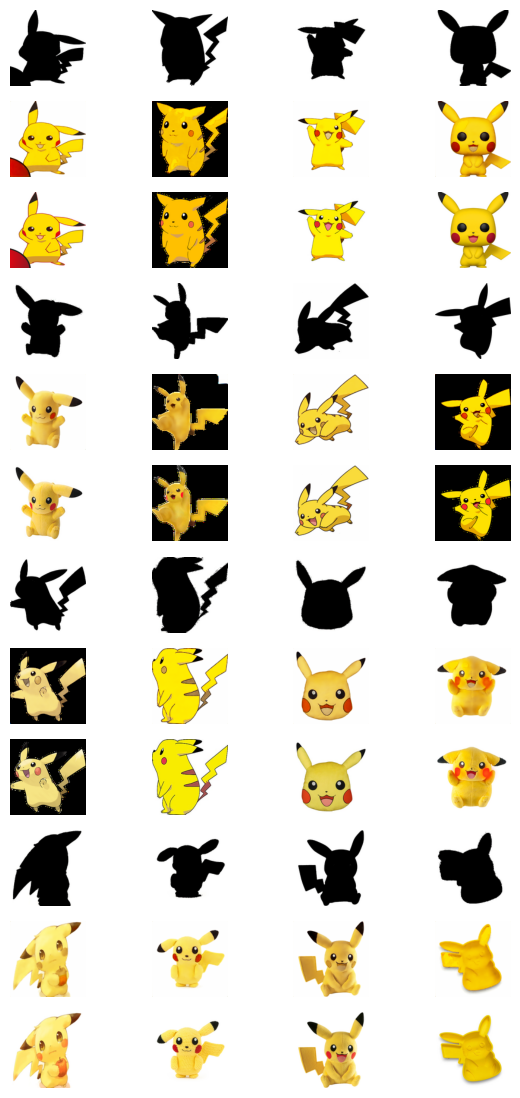

In [149]:
poke_gen.eval()

sample_label = torch.zeros((16,), dtype=torch.int, device=device)
sample_mask, sample_origin = next(iter(train_dataloader))

sample_img = poke_gen(sample_label.to(device), sample_mask.to(device))

num_samples_to_show = 16
fig, axes = plt.subplots(12, 4, figsize=(7, 14))

for i in range(num_samples_to_show):
    sample_maski = sample_mask[i].numpy().transpose(1, 2, 0)
    sample_imgi = sample_img[i].detach().cpu().numpy().transpose(1, 2, 0)
    sample_origini = sample_origin[i].detach().cpu().numpy().transpose(1, 2, 0)

    axes[(i // 4) * 3, i % 4].imshow(sample_maski, cmap='gray')
    axes[(i // 4) * 3, i % 4].axis('off')

    axes[(i // 4) * 3 + 1, i % 4].imshow(sample_imgi)
    axes[(i // 4) * 3 + 1, i % 4].axis('off')

    axes[(i // 4) * 3 + 2, i % 4].imshow(sample_origini)
    axes[(i // 4) * 3 + 2, i % 4].axis('off')

plt.show()